# 02 - Taoyuan Open Street Map network download

This notebook __downloads and uploads the Open Street Map network__ for the Taoyuan project's area of interest.

* Primero se descargó la red del área de interés, con bbox. Demasiados nodos. [+375000]
* Luego se descargó la red del área de interés con polygon y buffer de 500 metros, demasiados nodos. [+315000]
* Luego se descargó la red igual, pero consolidando nodos a 10 metros (Junta los edges en un nodo en común), demasiados nodos [214974]
* Finalmente se decidió acotar el área de interés a la zona urbana (sin montañas, llamada __drawn_aoi__), descargar toda la red sin consolidar en esa área y utilizar hexágonos resolución 11 para definir tiempos (Ver notebook 03 y notebook 04)

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path already loaded.")
    import aup

repo_path = str(module_path)+"/"
print(f"Repo path: {repo_path}")

Path already loaded.
Repo path: /home/observatorio/Documents/repos/accesibilidad-urbana/


## __Notebook config__

In [3]:
# ----- ----- ----- Input configuration
project_path = repo_path + "data/projects/30_taojuan/"

# ----- ----- ----- Process configuration
projected_crs = "EPSG:32651"

# ----- ----- ----- Saving configuration
# save output to database?
save = True
if_exists='replace'

## __Load area of interest__

In [4]:
# Load area of interest
aoi_schema = 'projects_research'
aoi_table = 'taoyuan_aoi'
aoi_name = 'taoyuan_drawn_aoi'

query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"aoi_name\" LIKE \'{aoi_name}\'"
aoi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
aoi_gdf = aoi_gdf.set_crs("EPSG:4326")

# Show
print(aoi_gdf.crs)
print(aoi_gdf.shape)
aoi_gdf.head(1)

EPSG:4326
(1, 2)


,geometry,aoi_name
0,"MULTIPOLYGON (((121.26668 25.12071, 121.26901 ...",taoyuan_drawn_aoi


In [13]:
aoi_gdf = gpd.read_file(project_path+"/area_of_interest/Taoyuan City Limit.shp")
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

# Simplify data
#aoi_gdf['aoi_name'] = 'taoyuan_drawn_aoi'
#aoi_gdf.drop(columns=['COUNTYID','COUNTYCODE','COUNTYNAME','COUNTYENG'],inplace=True)

# Show
print(aoi_gdf.crs)
print(aoi_gdf.shape)
aoi_gdf.head(2)

EPSG:4326
(1, 5)


,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,H,68000,桃園市,Taoyuan City,"POLYGON ((121.26381 25.12198, 121.26668 25.120..."


<Axes: >

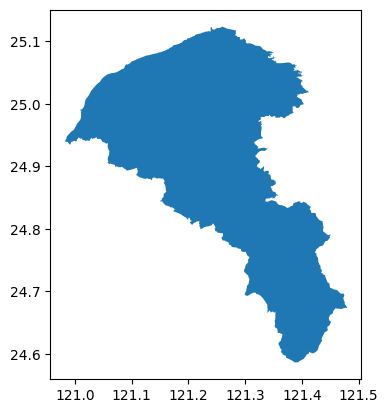

In [14]:
aoi_gdf.plot()

## __Create area of interest buffer__

In [15]:
# Create buffer
aoi_buffer = aoi_gdf.to_crs(projected_crs).buffer(500)

# Turn into GeoDataFrame
aoi_buffer_gdf = gpd.GeoDataFrame(aoi_buffer)
aoi_buffer_gdf.rename(columns={0:'geometry'},inplace=True)
aoi_buffer_gdf= aoi_buffer_gdf.set_geometry('geometry',crs=projected_crs)

# Change back crs
aoi_buffer_gdf = aoi_buffer_gdf.to_crs("EPSG:4326")

# Show
print(aoi_buffer_gdf.crs)
print(aoi_buffer_gdf.shape)
aoi_buffer_gdf.head(1)

EPSG:4326
(1, 1)


,geometry
0,"POLYGON ((121.05832 24.93682, 121.05829 24.936..."


<Axes: >

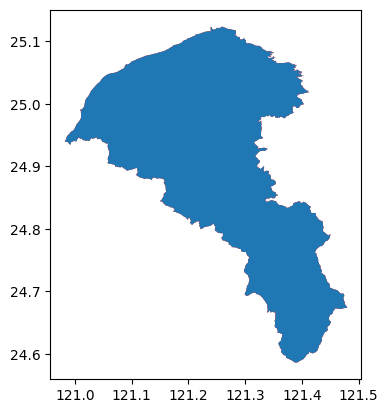

In [16]:
fig,ax = plt.subplots()

aoi_gdf.plot(ax=ax,zorder=1)
aoi_buffer_gdf.plot(ax=ax,color='red',zorder=0)

## __Download Open Street Map network__

In [17]:
# Create Network
G,nodes_gdf,edges_gdf = aup.create_osmnx_network(aoi_gdf,
                                                 how='from_polygon',
                                                 network_type='all',
                                                 consolidate=(False, 5),
                                                 projection_crs=projected_crs
                                                )

Created OSMnx graph from bounding polygon.
Converted OSMnx graph to 83131 nodes and 209358 edges GeoDataFrame.
Filtered columns.
Column: osmid in edges gdf, has a list in it, the column data was converted to string.
Column: lanes in edges gdf, has a list in it, the column data was converted to string.
Column: name in edges gdf, has a list in it, the column data was converted to string.
Column: highway in edges gdf, has a list in it, the column data was converted to string.
Column: maxspeed in edges gdf, has a list in it, the column data was converted to string.
Column: bridge in edges gdf, has a list in it, the column data was converted to string.
Column: ref in edges gdf, has a list in it, the column data was converted to string.
Column: tunnel in edges gdf, has a list in it, the column data was converted to string.
Column: access in edges gdf, has a list in it, the column data was converted to string.
Column: width in edges gdf, has a list in it, the column data was converted to stri

In [18]:
# Show
print(nodes_gdf.crs)
print(nodes_gdf.shape)
nodes_gdf.head(1)

EPSG:4326
(83131, 4)


,x,y,street_count,geometry
osmid,,,,
31365361,121.311472,25.015733,4,POINT (121.31147 25.01573)


In [19]:
# Show
print(edges_gdf.crs)
print(edges_gdf.shape)
edges_gdf.head(1)

EPSG:4326
(209358, 15)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
u,v,key,,,,,,,,,,,,,,,
31365361,12550977742,0,7995384,False,2,大業路一段,unclassified,50,9.136343,"LINESTRING (121.31147 25.01573, 121.31149 25.0...",<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>


<Axes: >

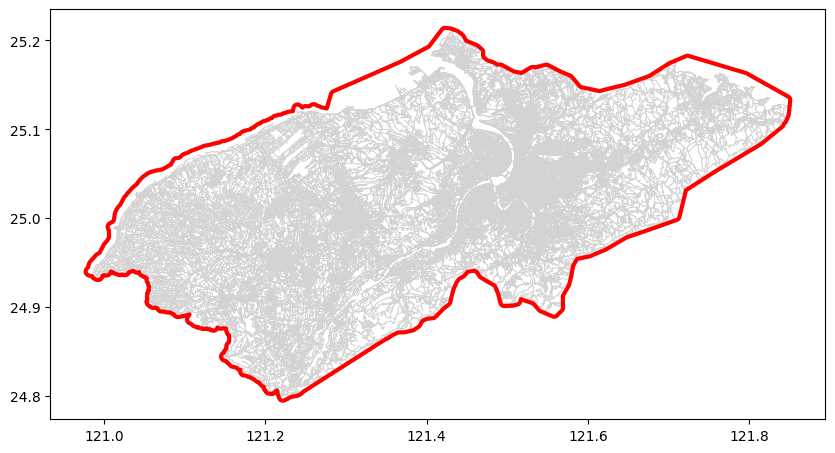

In [11]:
# Show
fig,ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi_buffer_gdf.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

## __Local save__ (For tests)

In [12]:
nodes_gdf = nodes_gdf.reset_index()
edges_gdf = edges_gdf.reset_index()

nodes_gdf.to_file(project_path + f"nodes_distance_matrix/taoyuan_nodes_drawnaoi_cons5m.gpkg")
edges_gdf.to_file(project_path + f"nodes_distance_matrix/taoyuan_edges_drawnaoi_cons5m.gpkg")

## __Upload to database__

In [12]:
save_schema = 'projects_research'
nodes_save_table = 'taoyuan_nodes_drawnaoi_cons'
edges_save_table = 'taoyuan_edges_drawnaoi_cons'

# Save Network
if save:

    # Resets index (allows delete duplicates in DBeaver using u, v, osmid)
    nodes_gdf = nodes_gdf.reset_index()
    edges_gdf = edges_gdf.reset_index()
    
    print(f"Uploading nodes.")
    aup.gdf_to_db_slow(nodes_gdf, nodes_save_table, save_schema, if_exists=if_exists)
    print(f"Uploading edges.")
    aup.gdf_to_db_slow(edges_gdf, edges_save_table, save_schema, if_exists=if_exists)

Uploading nodes.
Uploading edges.
